In [42]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import os
import PIL
import plotly.express as px
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score,confusion_matrix,log_loss
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D,BatchNormalization,MaxPool2D,Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imageio
#from scipy.signal import convolve2dro

import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image

In [43]:
precision=[]
recall=[]
f1_score=[]
accuracy=[]
data_link="D:/Covid19-dataset/"
train_path=data_link+"train"
test_path=data_link+"test"
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)
labels=os.listdir(train_dir)
print("Labels in the Data:",labels)

Labels in the Data: ['Covid', 'Normal', 'Viral Pneumonia']


In [44]:
train_count = len(list(train_dir.glob('*/*')))
test_count = len(list(test_dir.glob('*/*')))

print(" --------------------------------------")
print("  Images in Training set : {} \n  Images in Test det : {}".format(train_count,test_count))
print(" --------------------------------------")
cats=["Train","Test"]
vals=[train_count, test_count]
valdf=pd.DataFrame({"Directories":cats,"Count":vals})
fig=px.pie(valdf,names="Directories",values="Count",color="Directories",title="Images in Train and Test Directories",height=400,width=400)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.show()

 --------------------------------------
  Images in Training set : 251 
  Images in Test det : 66
 --------------------------------------


In [45]:
train=os.listdir(train_dir)
test=os.listdir(test_dir)
train_data=[]
test_data=[]
types=['Covid', 'Normal', 'Viral Pneumonia']
for i in train:
    train_data.append(len(os.listdir(os.path.join(train_dir,i))))
for i in test:
    test_data.append(len(os.listdir(os.path.join(test_dir,i))))
xrayimages=pd.DataFrame({"Category":types,"Train":train_data,"Test":test_data})
for i in range(len(xrayimages)):
    print("---------------------------------------------------")
    print("  Available training images in {} is {}".format(xrayimages['Category'][i],xrayimages['Train'][i]))
    print("  Available test images in {} is {}".format(xrayimages['Category'][i],xrayimages['Test'][i]))
    print("----------------------------------------------------")

---------------------------------------------------
  Available training images in Covid is 111
  Available test images in Covid is 26
----------------------------------------------------
---------------------------------------------------
  Available training images in Normal is 70
  Available test images in Normal is 20
----------------------------------------------------
---------------------------------------------------
  Available training images in Viral Pneumonia is 70
  Available test images in Viral Pneumonia is 20
----------------------------------------------------


In [46]:
fig=px.pie(xrayimages,names="Category",values="Train",color="Category",title="Number of Images Train Set",height=400,width=400)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.show()

In [47]:
fig=px.pie(xrayimages,names="Category",values="Test",color="Category",title="Number of Images Test Set",height=400,width=400)
fig.update_traces(textposition='inside',textinfo='percent+label')
fig.show()

In [48]:
covid_train = list(train_dir.glob("Covid/*"))
pnemonia_train = list(train_dir.glob("Viral Pneumonia/*"))
normal_train = list(train_dir.glob("Normal/*"))

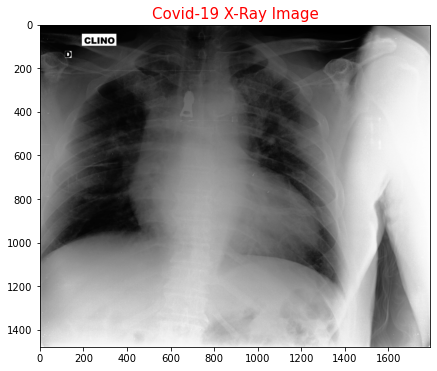

In [49]:
covid_img = PIL.Image.open(covid_train[31])        # using pillow library
plt.figure(figsize=(7,7))
plt.title("Covid-19 X-Ray Image",fontsize=15,color="red")
plt.imshow(covid_img)

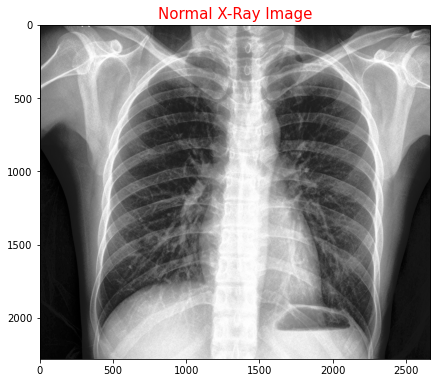

In [50]:
normal_img = PIL.Image.open(normal_train[20])
plt.figure(figsize=(7,7))
plt.title("Normal X-Ray Image",fontsize=15,color="red")
plt.imshow(normal_img)

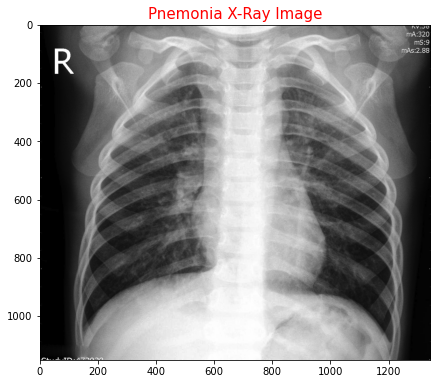

In [51]:
pnemonia_img = PIL.Image.open(pnemonia_train[12])
plt.figure(figsize=(7,7))
plt.title("Pnemonia X-Ray Image",fontsize=15,color="red")
plt.imshow(pnemonia_img)

# Loading tensorflow and preprocessing

In [52]:
# ImageDataGenerator is used to transform the image to image array
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [53]:
batch_size = 16    
img_h = 300
img_w = 300

In [54]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(img_h, img_w),
  batch_size=batch_size)
train_generator = train_datagen.flow_from_directory(
        train_path,
        classes=labels,
        target_size=(img_h, img_w),
        batch_size=32,
        class_mode='categorical')

Found 251 files belonging to 3 classes.
Found 251 images belonging to 3 classes.


In [55]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    image_size =(img_h,img_w),
    batch_size = batch_size)
test_generator = test_datagen.flow_from_directory(
        test_path,
        classes=labels,
        target_size=(img_h,img_w),
        batch_size=32,
        class_mode='categorical')

Found 66 files belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [56]:
class_names = train_ds.class_names
print(class_names)

['Covid', 'Normal', 'Viral Pneumonia']


# Visualizing the dataset

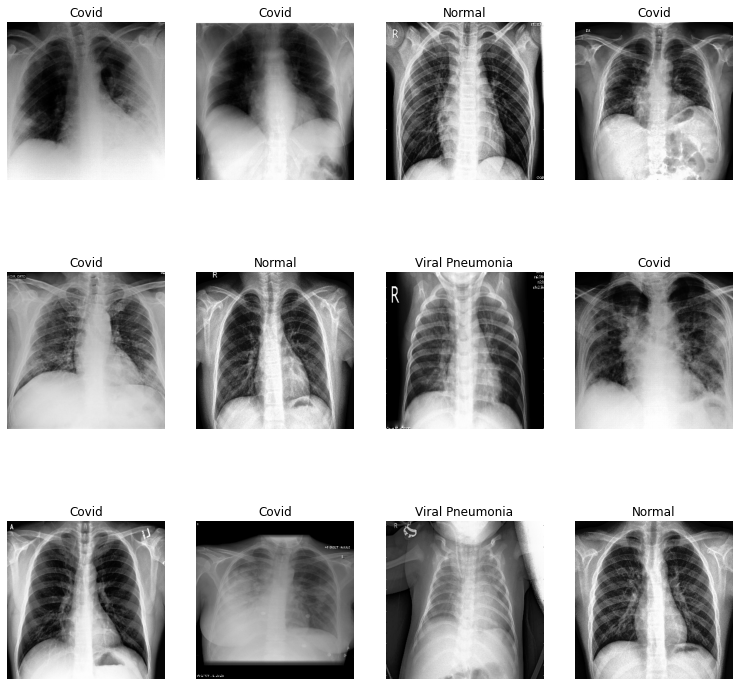

In [57]:
totplot=12
plt.figure(figsize=(13, 13))
for images, labels in train_ds.take(1):
    for i in range(totplot):
        ax = plt.subplot(int(totplot/4), int(totplot/3), i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [58]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 300, 300, 3)
(16,)


In [59]:
normalizing_layer = layers.experimental.preprocessing.Rescaling(1./255)

# Keras Sequencial Model for CNN

In [60]:
num_classes = 3

model_sq = Sequential([
    normalizing_layer,
    layers.Conv2D(16,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding = "same", activation = "relu"),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128,activation = "relu"),
    layers.Dense(num_classes),
    layers.Activation('softmax')
])                                   # Relu-> rectified linear unit

In [61]:
model_sq.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])   #tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [62]:
epochs=30
history_sq = model_sq.fit(
  train_generator,
  batch_size=16,
  validation_data=test_generator,
  epochs=epochs)

Epoch 1/30
8/8 [==============================] - 98s 12s/step - loss: 1.0886 - accuracy: 0.4462 - val_loss: 1.0874 - val_accuracy: 0.3939
Epoch 2/30
8/8 [==============================] - 47s 6s/step - loss: 1.0762 - accuracy: 0.4422 - val_loss: 1.0791 - val_accuracy: 0.3939
Epoch 3/30
8/8 [==============================] - 48s 6s/step - loss: 1.0583 - accuracy: 0.4422 - val_loss: 1.0394 - val_accuracy: 0.3939
Epoch 4/30
8/8 [==============================] - 49s 6s/step - loss: 1.0301 - accuracy: 0.4661 - val_loss: 1.0177 - val_accuracy: 0.6212
Epoch 5/30
8/8 [==============================] - 50s 6s/step - loss: 0.9645 - accuracy: 0.5458 - val_loss: 0.8568 - val_accuracy: 0.5455
Epoch 6/30
8/8 [==============================] - 48s 6s/step - loss: 0.8568 - accuracy: 0.6335 - val_loss: 0.7605 - val_accuracy: 0.6364
Epoch 7/30
8/8 [==============================] - 48s 6s/step - loss: 0.7620 - accuracy: 0.6693 - val_loss: 0.6690 - val_accuracy: 0.6818
Epoch 8/30
8/8 [=================

In [63]:
model_sq.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, None, None, None)  0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 16)    448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, None, None, 16)    0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, None, None, 32)    0         
_________________________________________________________________
flatten_2 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [64]:
train_acc = history_sq.history['accuracy']
test_acc = history_sq.history['val_accuracy']
train_loss = history_sq.history['loss']
test_loss = history_sq.history['val_loss']
model_stat_sq=pd.DataFrame({
    "Epoch":[i+1 for i in range(30)],
    "Training Loss":train_loss,
    "Test Loss":test_loss,
    "Training Accuracy":train_acc,
    "Test Accuracy":test_acc
})
model_stat_sq.to_csv("model_sq.csv")
model_stat_sq

,Epoch,Training Loss,Test Loss,Training Accuracy,Test Accuracy
0,1,1.088556,1.087358,0.446215,0.393939
1,2,1.076245,1.079111,0.442231,0.393939
2,3,1.058254,1.039428,0.442231,0.393939
3,4,1.030123,1.017682,0.466135,0.621212
4,5,0.964505,0.856793,0.545817,0.545455
5,6,0.856814,0.760496,0.633466,0.636364
6,7,0.762043,0.669041,0.669323,0.681818
7,8,0.761636,0.641229,0.641434,0.742424
8,9,0.767272,0.667150,0.637450,0.651515
9,10,0.697923,0.631820,0.669323,0.651515


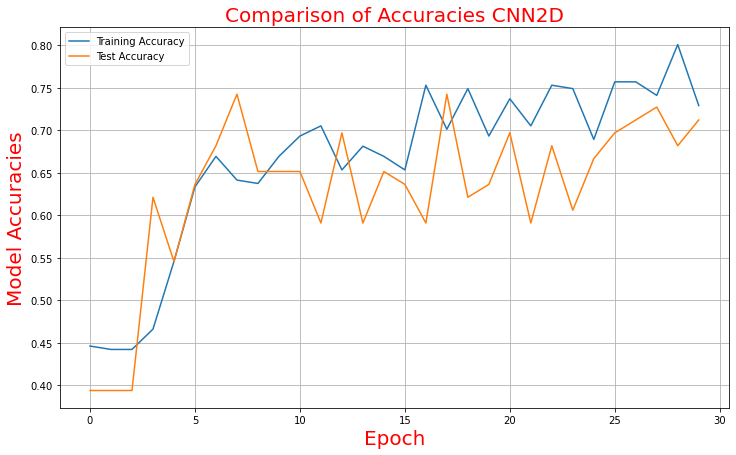

In [66]:
model_stat_sq.iloc[:,3:].plot(kind="line",figsize=(12,7))
plt.title("Comparison of Accuracies CNN2D",fontsize=20,color="red")
plt.xlabel("Epoch",fontsize=20,color="red")
plt.ylabel("Model Accuracies",fontsize=20,color="red")
plt.grid()
plt.show()

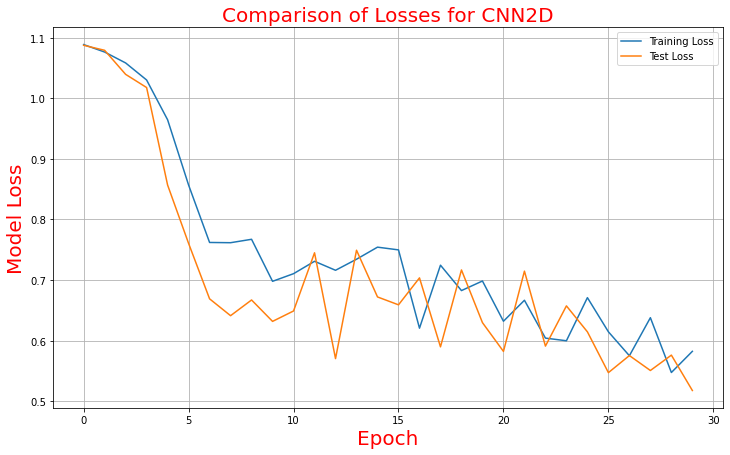

In [67]:
model_stat_sq.iloc[:,1:3].plot(kind="line",figsize=(12,7))
plt.title("Comparison of Losses for CNN2D",fontsize=20,color="red")
plt.xlabel("Epoch",fontsize=20,color="red")
plt.ylabel("Model Loss",fontsize=20,color="red")
plt.grid()
plt.show()

In [71]:
y_pred = model_sq.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.classes
sq_out=pd.DataFrame({"Actual":class_labels,"Predicted":y_pred})     # dataframe for actual and predicted
sq_out["Actual"]=sq_out["Actual"].replace(sq_out["Actual"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
sq_out["Predicted"]=sq_out["Predicted"].replace(sq_out["Predicted"].unique(),['Covid', 'Normal', 'Viral Pneumonia'])
precision.append(round(precision_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # Precision of the model
recall.append(round(recall_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # Recall of the model
f1_score.append(round(f1_score(sq_out["Actual"], sq_out["Predicted"], average='micro'),2)*100)     # F1-Score of the model
accuracy.append(round(model_stat_sq['Training Accuracy'].max(),4)*100)
print("Accuracy for CNN Model => {}%".format(round(model_stat_sq['Training Accuracy'].max(),4)*100))
ct_sq=pd.crosstab(sq_out["Actual"], sq_out["Predicted"], rownames=['True'], colnames=['Predicted'], margins=True)
ct_sq.iloc[:3,:3]

TypeError: 'list' object is not callable

In [ ]:
def chest_prediction(pres,dr):
    im = mpimg.imread(pres)     # reading images
    img = image.load_img(pres,target_size=(img_h,img_w))      # reading images
    img = image.img_to_array(img)     # converting present image to array
    img = np.expand_dims(img,axis=0)   
    pred=model_sq.predict(img)    # predict images
    pred_1=np.argmax(pred, axis=1)
    if pred_1[0]==0:
        print("Covid Affected Chest X-Ray Image")
        plt.figure(figsize=(14,7))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Covid Chest X-Ray".format(dr),fontsize=18,color="#FF4500")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==1:
        print("Normal Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Normal X-Ray".format(dr),fontsize=18,color="#046307")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    elif pred_1[0]==2:
        print("Viral Pneumonia Affected Chest X-Ray Image")
        plt.figure(figsize=(12,6))
        picpred=imageio.imread(pres)
        plt.title("Original => {} \nPredicted => Viral Pneumonia Chest X-Ray".format(dr),fontsize=18,color="#DC143C")
        plt.imshow(picpred)
        plt.axis('off')
        plt.show()
    
lbldir=os.listdir(test_path)
print(lbldir)
pres=os.path.join(test_path,lbldir[0],os.listdir(test_path+"/"+lbldir[0])[0])
chest_prediction(pres,lbldir[0])
pres=os.path.join(test_path,lbldir[1],os.listdir(test_path+"/"+lbldir[1])[0])
chest_prediction(pres,lbldir[1])
pres=os.path.join(test_path,lbldir[2],os.listdir(test_path+"/"+lbldir[2])[4])
chest_prediction(pres,lbldir[2])

In [ ]:
model_sq.save('pneumonia_model_seq.h5')